In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import warnings
import numpy as np
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

In [2]:
print("Loading data file now, this could take a while depending on file size")
start = time.time()
data = pd.read_csv('Train_set.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading data file now, this could take a while depending on file size
Loading took 0.04 seconds


In [3]:
data = data.dropna()

In [4]:
data["week_by_year"] = data["Year"].astype(str) + "-" + data["Week_no"].astype(str)

In [5]:
data = data.groupby('week_by_year')['Count'].sum().reset_index()

In [6]:
data.set_index('week_by_year', inplace=True)

In [7]:
data.head()

,Count
week_by_year,
2013-1,744.0
2013-10,675.0
2013-11,694.0
2013-12,562.0
2013-13,496.0


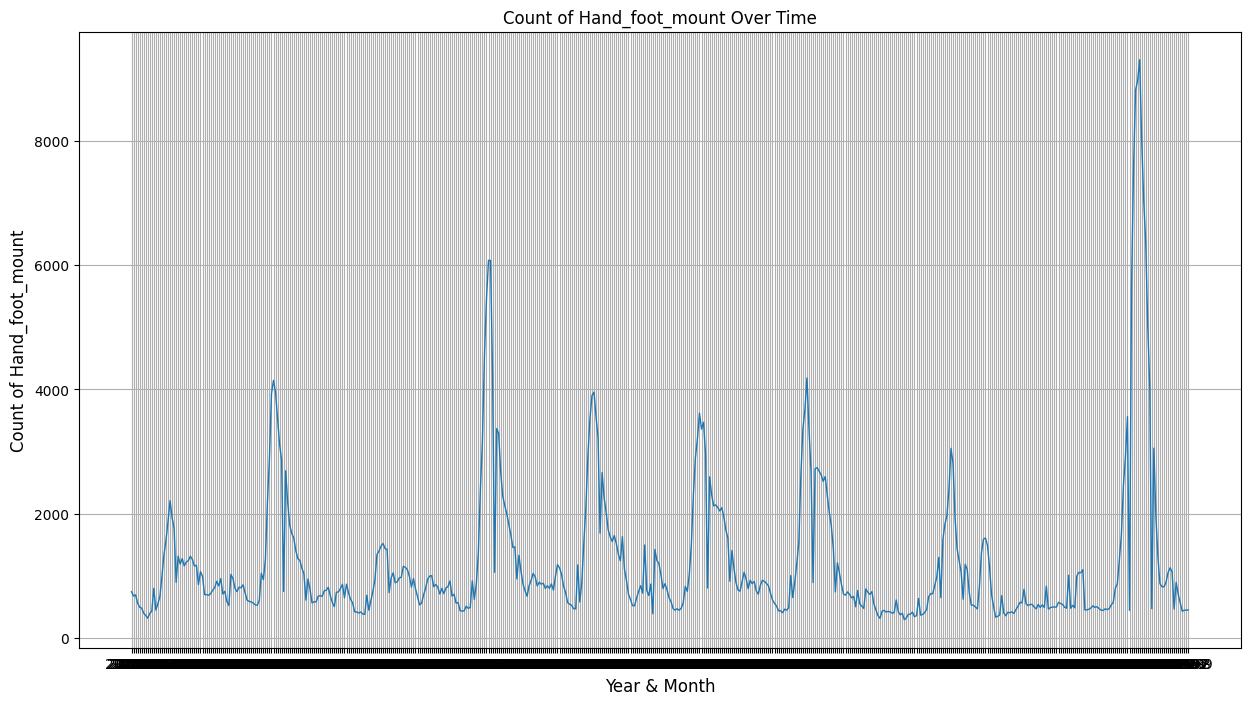

In [8]:
# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(data['Count'] ,label='temp',linewidth=1)
# Add labels and title
plt.xlabel('Year & Month' , fontsize=12)
plt.ylabel('Count of Hand_foot_mount' , fontsize=12)
plt.title('Count of Hand_foot_mount Over Time')
# Show the plot
plt.grid(True)
plt.show()

In [9]:
train_start_dt = '2013-01-01'
test_start_dt = '2021-01-31'

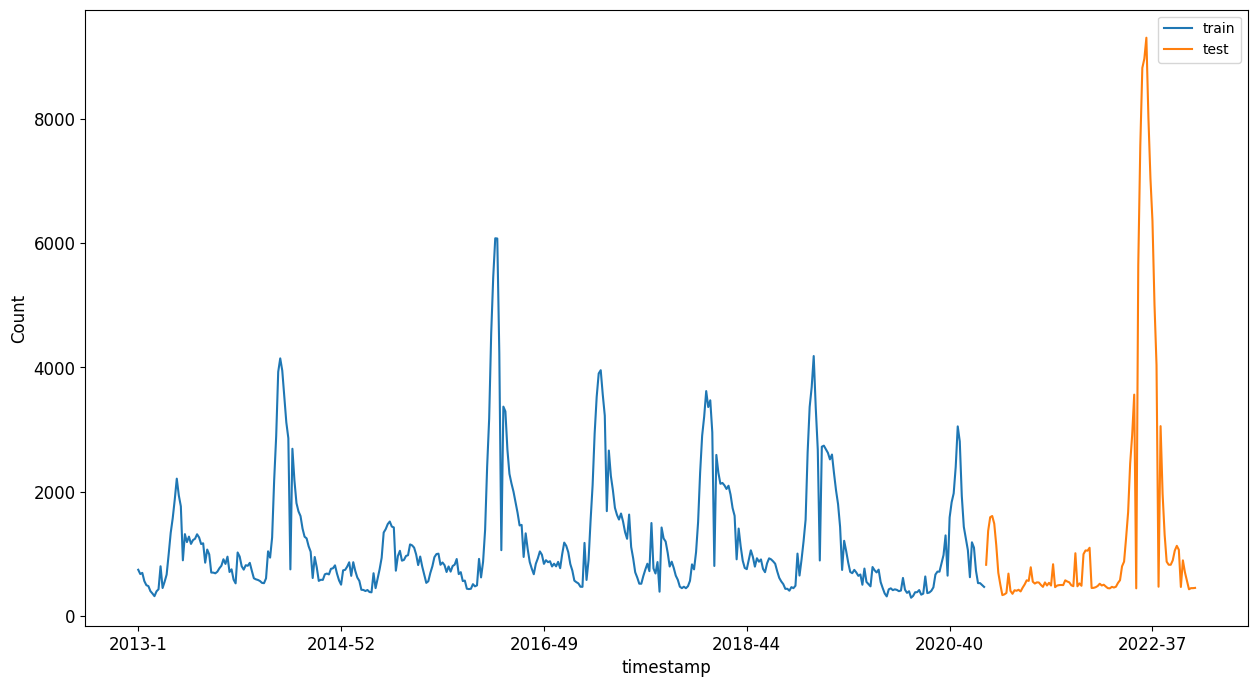

In [10]:
data[(data.index < test_start_dt) & (data.index >= train_start_dt)][['Count']].rename(columns={'Count':'train'}) \
    .join(data[test_start_dt:][['Count']].rename(columns={'Count':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [11]:
train = data.copy()[(data.index >= train_start_dt) & (data.index < test_start_dt)][['Count']]
test = data.copy()[data.index >= test_start_dt][['Count']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (418, 1)
Test data shape:  (104, 1)


In [12]:
scaler = MinMaxScaler()
train['Count'] = scaler.fit_transform(train)

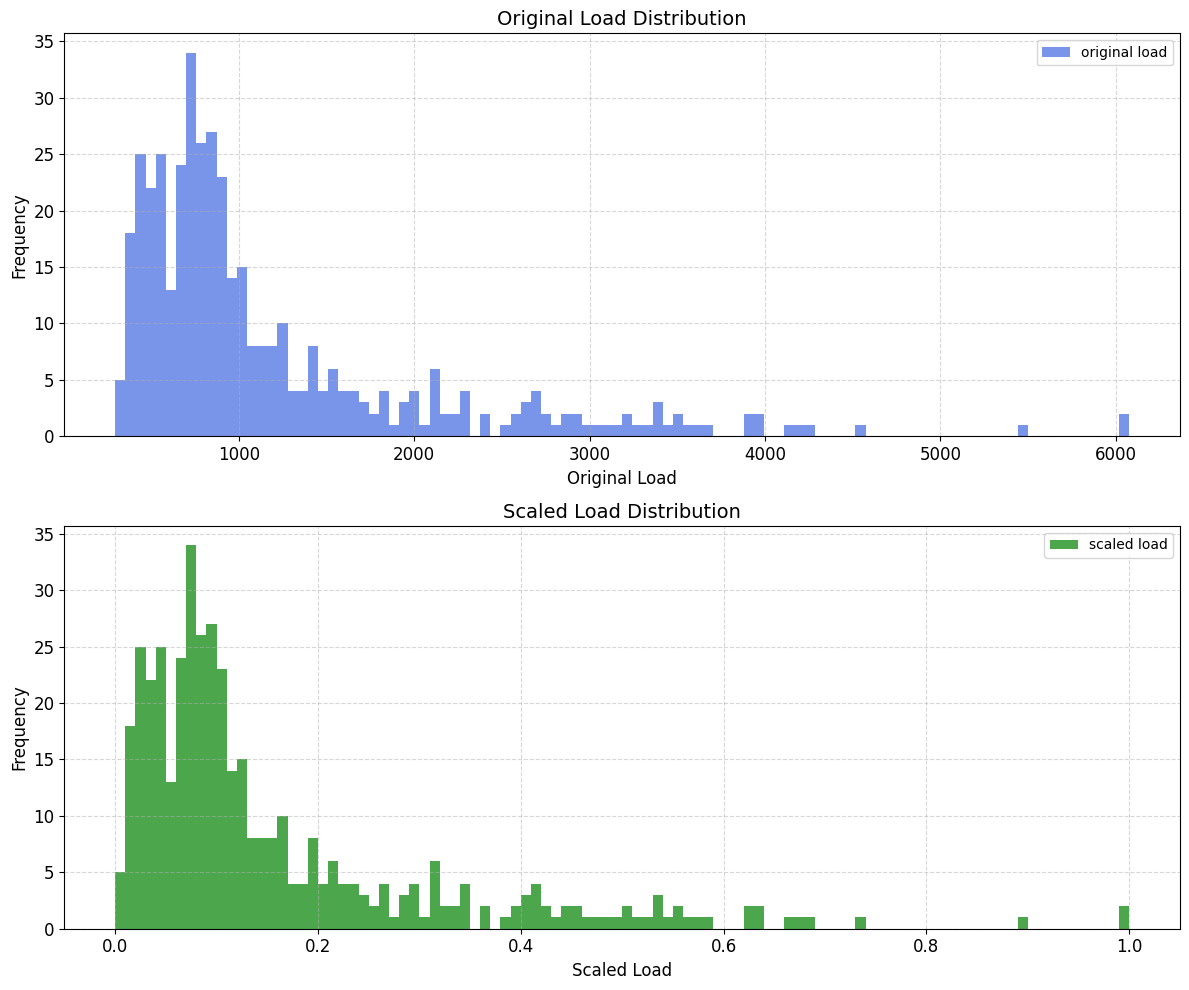

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original load
data[(data.index >= train_start_dt) & (data.index < test_start_dt)][['Count']].rename(columns={'Count': 'original load'}).plot.hist(
    bins=100, fontsize=12, ax=axes[0], color='royalblue', alpha=0.7)
axes[0].set_title('Original Load Distribution', fontsize=14)
axes[0].set_xlabel('Original Load', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot the scaled load
train.rename(columns={'Count': 'scaled load'}).plot.hist(
    bins=100, fontsize=12, ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('Scaled Load Distribution', fontsize=14)
axes[1].set_xlabel('Scaled Load', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
test['Count'] = scaler.transform(test)
test.head()

,Count
week_by_year,
2021-1,0.091632
2021-10,0.186030
2021-11,0.224066
2021-12,0.227351
2021-13,0.205913


In [15]:
train.head()

,Count
week_by_year,
2013-1,0.077801
2013-10,0.065871
2013-11,0.069156
2013-12,0.046335
2013-13,0.034924


In [16]:
 # เอาให้แน่ใจว่า index คือ datetime
train.index.freq = 'w' # ปลับเลือกความถี่ 
test.index.freq = 'w'

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm  
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [26]:
SARIMAX_model = pm.auto_arima(data,
                           start_p=0, 
                           start_q=0,
                           test='adf',  # ใช้ ADF test เพื่อหา d
                           max_p=3, # ปรับเปลี่ยนตามความซับซ้อนของข้อมูล
                           max_q=3, # คล้ายกับ max_p ปรับเปลี่ยนให้เข้ากับข้อมูลเพื่อเพิ่มความสามารถของโมเดลในการคำนวณความผิดพลาด
                           m=52, # m คือ seasonality (12 สำหรับข้อมูลรายเดือน)
# ข้อมูลรายเดือน: m=12
# ข้อมูลรายไตรมาส: m=4
# ข้อมูลรายสัปดาห์: m=52
# ข้อมูลรายวัน:  m=7
                           start_P=0, # เริ่มต้นที่ 0 แต่สามารถเปลี่ยนได้ถ้าคุณเชื่อว่ามีอิทธิพลจากฤดูกาลในช่วงก่อนหน้า
                           seasonal=True,
                           d=None, # None
                           D=1,  # ให้ auto_arima ค้นหา d ที่เหมาะสม
                           trace=True, # ติดตามความก้าวหน้าในการสร้างโมเดล
                           error_action='ignore', # แสดงเตือนเมื่อเกิดข้อผิดพลาด 
                           suppress_warnings=True, # แสดงข้อความเตือนในระหว่างการทำงาน
                           stepwise=True) # True

# ดูค่าที่ auto_arima คำนวณได้
SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=44.03 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=8107.070, Time=0.69 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=7327.093, Time=44.26 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=62.43 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=8109.550, Time=0.40 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=7378.806, Time=2.48 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=inf, Time=113.42 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=89.08 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=61.53 sec


KeyboardInterrupt: 

In [33]:
model = SARIMAX(data, order=(1,0, 0), seasonal_order=(1, 1, 0, 52))
model = model.fit(disp=1)

C:\Users\singk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\singk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [34]:
n = 104

In [35]:
prediction = model.get_forecast(steps=n)
prediction_index = test.index

C:\Users\singk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\singk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [36]:
# ค่าที่คาดการณ์
predicted = prediction.predicted_mean
# กรอบความเชื่อมั่น
confidence_intervals = prediction.conf_int(alpha=0.40)

In [37]:
test_values = np.array(test)  # Replace with your actual test values
predicted_values = np.array(predicted)
mape = np.mean(np.abs((test_values - predicted_values) / test_values)) * 100

MAPE: 3703537.91%


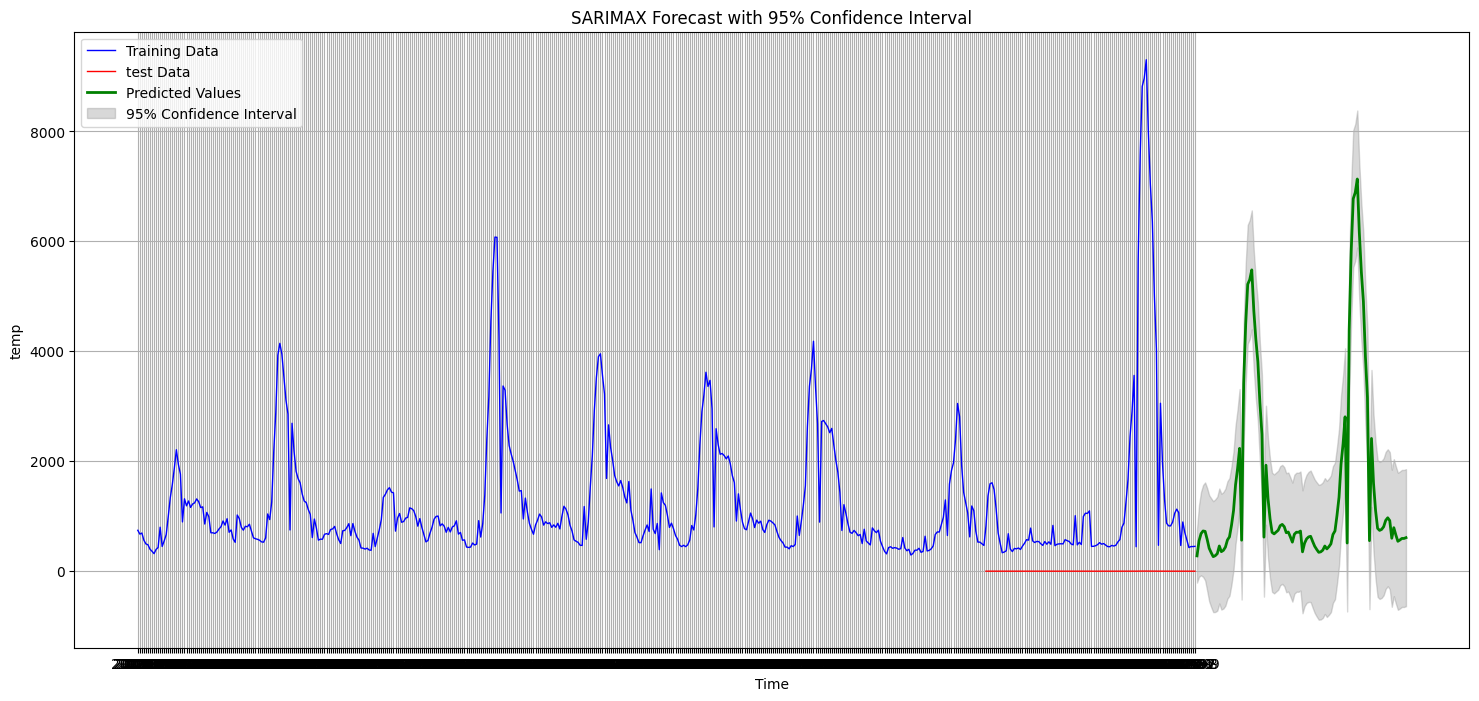

In [38]:
# สร้างกราฟ
print(f'MAPE: {mape:.2f}%')
plt.figure(figsize=(18, 8))
plt.plot( data, label='Training Data', color='blue',linewidth=1)  # ข้อมูลที่ใช้ฝึก
plt.plot( test, label='test Data', color='red',linewidth=1)
plt.plot( predicted, label='Predicted Values',color ='green',linewidth=2)  # ค่าที่คาดการณ์

# กรอบความเชื่อมั่น
plt.fill_between(predicted.index[-n:], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# เพิ่มรายละเอียดกราฟ
plt.title('SARIMAX Forecast with 95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('temp')
plt.legend()
plt.grid()
plt.show()

In [24]:
prediction_y1_np=np.array([predicted])

In [25]:
# Flatten the arrays to 1D
np_original_data_y1 = prediction_y1_np.flatten()

# Combine the data from the three arrays
combined_data = np.concatenate([np_original_data_y1])

# Create an id array from 1 to the length of combined_data
id_array = np.arange(40195, 40195 + len(combined_data))

In [27]:
# Create a DataFrame
df = pd.DataFrame({
    '_id': id_array,
    'Pred': combined_data
})

# Specify the CSV file name
csv_file = 'predictions_1.csv'  # Change this to your desired file name

# Save to CSV
df.to_csv(csv_file, index=False)